<a href="https://colab.research.google.com/github/khongpan/DOpredict/blob/master/AquaIoT_DOpredict00001_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 
import xml.etree.ElementTree as etree
import requests
import datetime as dt
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
#@title 
def DOsatCalc(t) :
  return 14.6-0.386*t+(6.54e-3)*t*t-(4.86e-5)*t*t*t

def DO(t,a,b,c) :
  return (a * np.exp(-b * t) + c)

server = 'agritronics.nstda.or.th'
script_path = '/ws/get.php?'
appkey = '0c5a295bd8c07a080d5306'
network_id = 'AQUA-IOT-02'
node_id = '4096'

def DownloadData(io_number,date):

  url = 'http://'+server+script_path+'appkey='+appkey+'&p='+ network_id+','+node_id+','+io_number+','+date
  #print(url)

  times=[]
  values=[]

  page = requests.get(url)
  root = etree.fromstring(page.content)
  io=root.find('IO')
  for d in io.findall('Data'):
     t=d.find('IODateTime').text
     v=float(d.find('Value').text)
     times.append(t)
     values.append(v)
  return times,values

def SetSite(nid):
  global network_id
  network_id=nid
  




In [ ]:
#@title 
io_do = '300'
io_temp = '304'
 
tz_th = timezone('Etc/GMT-7')
start_date = dt.datetime(2020, 7, 20, 0, 0, 0, 0, tzinfo=tz_th)
date_txt=''
 
 
do_s=[]
time_s=[]
 
 
def PrepareData():
  global do_s
  global time_s
  do_s=[]
  time_s=[]
  day_range=range(0,2)
  for day in day_range:
      date=start_date + dt.timedelta(days=day)
      date_txt = date.strftime('%Y-%m-%d')
  
  
      times=[]
      values=[]
      times,values = DownloadData(io_do,date_txt)
      do_s.extend(values)
      time_s.extend(times)
 

In [ ]:
#@title 
def PredictDO():
  fit_begin = round(12*19)
  fit_time = 2.5
  fit_point = round(fit_time*12)
  fit_end = fit_begin+fit_point-1
  
  predict_begin = fit_end+1
  predict_time = 8
  predict_point = predict_time*12
  predict_end = predict_begin+predict_point-1
      
  y_fit=do_s[fit_begin:fit_end+1]
  x_fit=np.linspace(0,fit_point-1,fit_point)
  #xdata=np.linspace(fit_begin,fit_end,fit_point)
  
  
  #popt, pcov = curve_fit(DO, x_fit, y_fit,bounds=([0,0,5], [1., 0.2, 10]))
  popt, pcov = curve_fit(DO, x_fit, y_fit)
  
  
  do_fit_s= DO(x_fit, *popt)
  x_predict=np.linspace(0+fit_point,predict_point+fit_point,predict_point)
  
  do_predict_s= DO(x_predict, *popt)
  
  time_all_s = np.linspace(0,(len(do_s)-1)*24/288,len(do_s))
  time_predict=np.linspace(predict_begin*24/288,predict_end*24/288,predict_point)
  time_fit=np.linspace(fit_begin*24/288,fit_end*24/288,fit_point)

  plt.rcParams["figure.figsize"] = (10,5)
  plt.title(network_id+' '+date_txt)
  plt.ylim(0,15)
  plt.xlim(0,30)
  plt.plot(time_all_s,do_s,'g-',label='real DO')
  plt.plot(time_fit,do_fit_s,'b-',label='fit')
  plt.plot(time_predict,do_predict_s,'r-',label='predict')
  plt.legend(['DO','fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt),'predict']);
  plt.show()


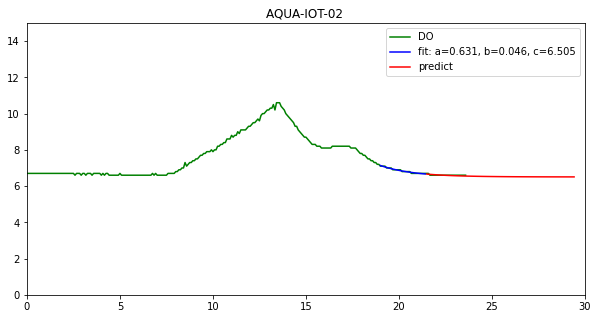

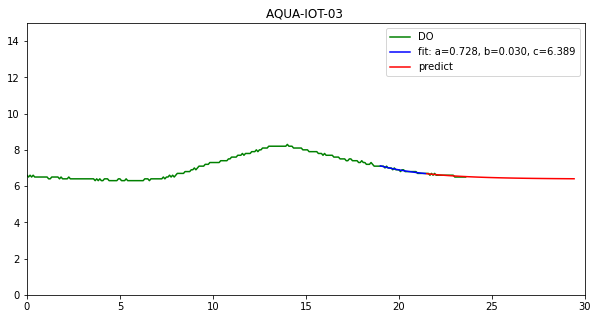

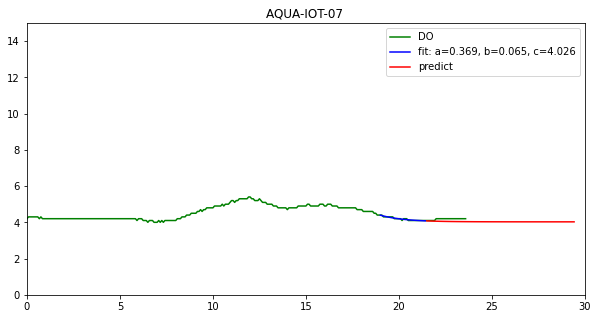

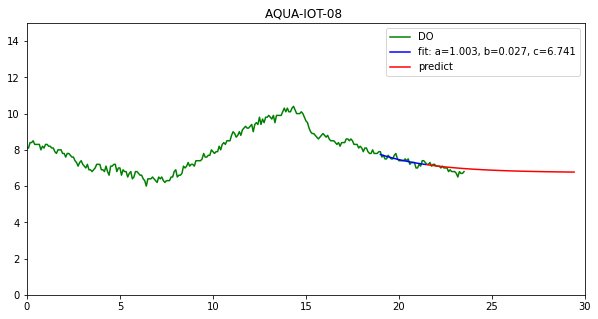

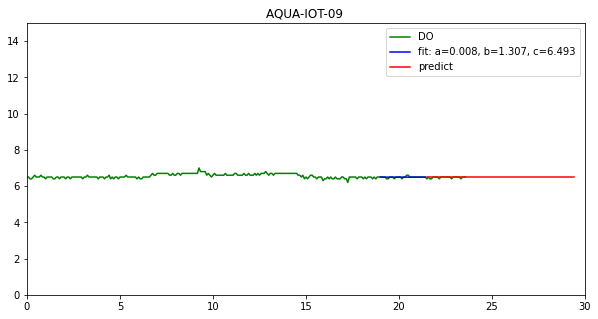

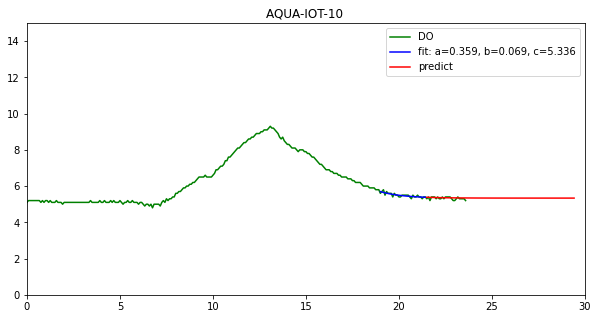

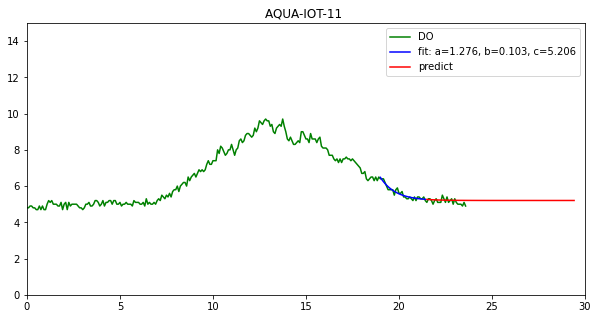

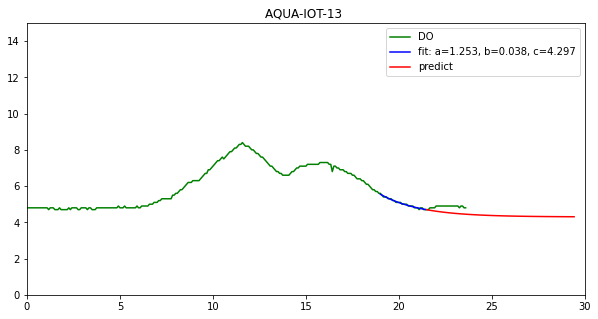

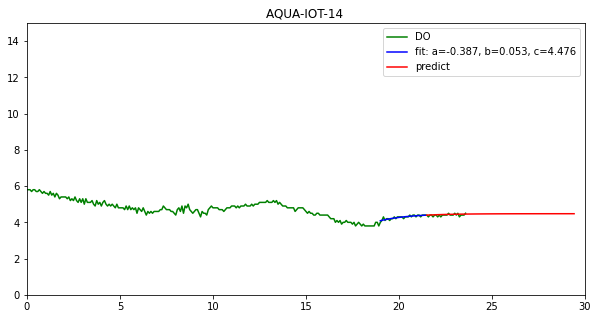

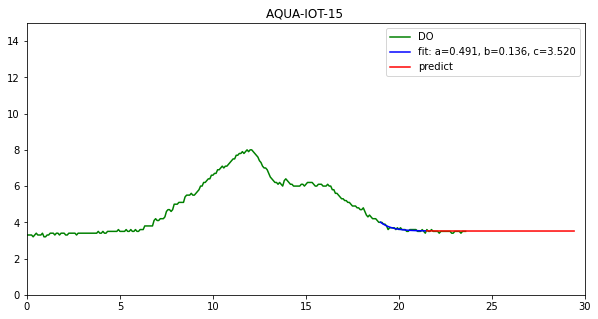

In [ ]:
#@title 
SiteLists=['AQUA-IOT-02',
           'AQUA-IOT-03',
           #'AQUA-IOT-04',
           #'AQUA-IOT-05',
           #'AQUA-IOT-06',
           'AQUA-IOT-07',
           'AQUA-IOT-08',
           'AQUA-IOT-09',
           'AQUA-IOT-10',
           'AQUA-IOT-11',
           #'AQUA-IOT-12',
           'AQUA-IOT-13',
           'AQUA-IOT-14',
           'AQUA-IOT-15']

for site in SiteLists :
  SetSite(site)
  PrepareData()
  PredictDO()
